In [ ]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants


from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

14:37:47: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:37:47: Debug: Adding duplicate animation handler for '1' type
14:37:47: Debug: Adding duplicate animation handler for '2' type
14:37:47: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:37:47: Debug: Adding duplicate animation handler for '1' type
14:37:47: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:451): Gtk-CRITICAL **: 14:37:48.202: gtk_window_resize: assertion 'height > 0' failed


In [3]:
# organisation of directory and creation of preprocessing folders
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)



###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap')) 

In [4]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motor_concat_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz_smoothed-6mm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.par
|--------------- sub-101410_task-motor_func2anat.nii.gz
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|-------

In [4]:
# first visualisation
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'T1w', 'T1w.nii.gz'))


(ipykernel_launcher.py:451): Gdk-WARNING **: 14:38:52.451: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [6]:
print(preproc_root)
print(bids_root)

/home/jovyan/data/subject101410/derivatives/preprocessed_data
/home/jovyan/data/subject101410


In [6]:
#skull-stripping
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz')
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "101410")

Done with BET.


In [7]:
# brain mask visualisation
fsleyesDisplay.load(resulting_mask_path)

In [8]:
# robust skull stripping
get_skull_stripped_anatomical(bids_root, preproc_root, "101410", robust = True)

Done with BET.


In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'T1w', 'T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

In [9]:
# applying the mask to the data to create the skull striped version and save it
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask.nii.gz') # The mask to use


apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)


In [16]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|--------------- tfMRI_MOTOR_RL_varnorm.nii.gz
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|--------- events_LR.csv
|--------- tfMRI_MOTOR_LR.nii
|------ tfMRI_MOTOR_RL/
|--------- events_RL.csv
|--------- tfMRI_MOTOR_RL.nii
|--- subject101410/


In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

In [11]:
# tissue segmentation, prend long la première fois désolé coline et greg
fast_target = betted_brain_path

segmentation_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_fast')


if not os.path.exists(segmentation_path + "_seg.nii.gz"):
    fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

In [24]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motor_concat_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.par
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|--------------- tfMRI_MOTOR_RL_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.mat/
|--- fMRI/
|------ tfMRI_MOTOR_LR/
|---

In [12]:
#  afficher les differents tissus segmentés en couleur slay
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-101410', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

In [ ]:
# pour concatenation, d'abord rescale la data
path_runLR = op.join(bids_root, "fMRI", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_LR.nii")
path_runRL = op.join(bids_root, "fMRI", "tfMRI_MOTOR_RL", "tfMRI_MOTOR_RL.nii")
out_dir = op.join(preproc_root, "sub-101410", "func")

def rescale_global_variance(img_path, out_dir, mask = None):
    img = nib.load(img_path)
    data = img.get_fdata() # la data est load en np.array, plus simple pour rescaling

    if mask == None :
        mask = data.mean(axis=-1) > 0 # mask qui prend les voxels avec une intensité (pas celles en dehors du cerveau)
        # si on fait pas le mask le background va dominer sur la variance
    
    brain_voxels = data[mask]
    # enlever la moyenne
    without_mean = brain_voxels - brain_voxels.mean(axis=1, keepdims=True)
    global_var = np.var(without_mean)
    print(f"{os.path.basename(img_path)}: global variance = {global_var:.4f}")

    scaled = data / np.sqrt(global_var)

    # enregistrer l'image rescaled
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_path = op.join(out_dir, base + "_varnorm.nii.gz")
    nib.save(nib.Nifti1Image(scaled, img.affine, img.header), out_path)
    return out_path



out_runLR = rescale_global_variance(path_runLR, out_dir) # on peut essayer avec le mask du skull-stripping aussi
out_runRL = rescale_global_variance(path_runRL, out_dir)


tfMRI_MOTOR_LR.nii: global variance = 311884.1305


In [13]:
# concatenate the normalised runs
from nibabel import concat_images

run1_norm = op.join(out_dir, "tfMRI_MOTOR_LR_varnorm.nii.gz")
run2_norm = op.join(out_dir, "tfMRI_MOTOR_RL_varnorm.nii.gz")

merged_out = op.join(out_dir, "sub-101410_task-motor_concat_varnorm.nii.gz")

concat_img = concat_images([run1_norm, run2_norm], axis=3)
nib.save(concat_img, merged_out)

NameError: name 'out_dir' is not defined

In [22]:
# visualisation de concatenate, mettre le mode film
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(merged_out)

In [23]:
# motion correction
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm.nii.gz")
path_moco_data = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco")
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_varnorm_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

In [25]:
# visualisation moco
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [26]:
# get and show motion parameters
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_varnorm_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000476,-0.005768,-0.002684,-0.330166,-0.163757,0.138294
1,0.000354,-0.005786,-0.002623,-0.328654,-0.164137,0.154693
2,0.000332,-0.006068,-0.002684,-0.331812,-0.155653,0.156803
3,0.000681,-0.005509,-0.002618,-0.332109,-0.156072,0.168333
4,0.000596,-0.005828,-0.002344,-0.334126,-0.155673,0.153350
...,...,...,...,...,...,...
563,0.000479,0.000813,-0.000212,0.052787,-0.037655,0.063665
564,0.000580,0.000813,-0.000331,0.064822,-0.038180,0.053299
565,0.000599,0.000813,-0.000288,0.053048,-0.047310,0.062754
566,0.000498,0.000813,-0.000284,0.051613,-0.043683,0.067995


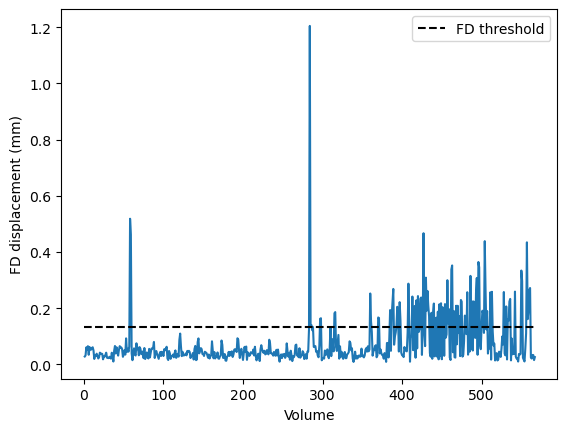

In [29]:
# framewise displacement plot
import matplotlib.pyplot as plt

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 567,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [6]:
# co-registration
from fsl.wrappers import flirt
# Paths
anat_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # source
func_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco.nii.gz")# reference

# Output 
out_dir = op.join(preproc_root, "sub-101410", "func")
out_func2anat = op.join(out_dir, "sub-101410_task-motor_func2anat.nii.gz")


flirt(func_path, anat_path, out=out_func2anat)


Final result: 
1.040116 0.014222 -0.012309 -3.824893 
-0.008137 1.030389 0.030353 -7.047419 
0.020630 0.009948 0.918612 2.447692 
0.000000 0.000000 0.000000 1.000000 



{}

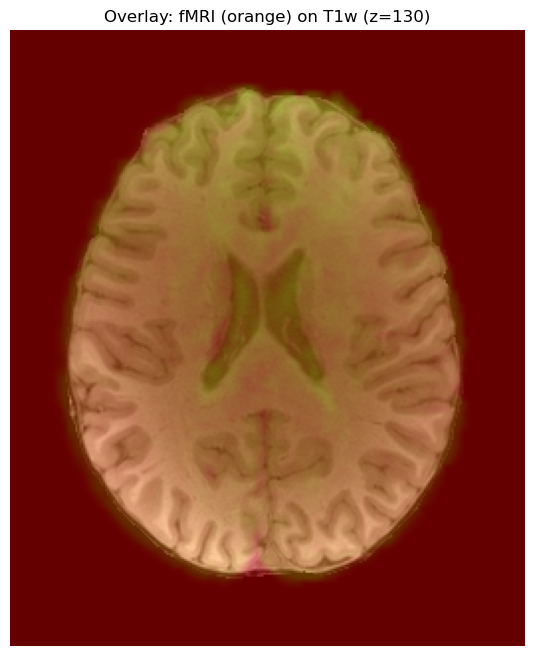

In [7]:
#  overlay plot, à modifier c'est grillé que c'est pas moi qui ai fait
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

# Paths
anat_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz')
func_registered = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_func2anat.nii.gz")

# Load data
anat_img = nib.load(anat_path)
func_img = nib.load(func_registered)

anat_data = anat_img.get_fdata()
func_data = func_img.get_fdata()

# Pick a middle slice (z direction)
z = anat_data.shape[2] // 2

# Extract single fMRI volume to display (first volume, or choose another)
func_slice = func_data[:, :, z, 0] if func_data.ndim == 4 else func_data[:, :, z]
anat_slice = anat_data[:, :, z]

# Normalize for plotting
func_norm = (func_slice - np.min(func_slice)) / (np.max(func_slice) - np.min(func_slice))

# Plot overlay
plt.figure(figsize=(8, 8))
plt.imshow(anat_slice.T, cmap='gray', origin='lower')
plt.imshow(func_norm.T, cmap='autumn', origin='lower', alpha=0.4)
plt.title(f"Overlay: fMRI (orange) on T1w (z={z})")
plt.axis('off')
plt.show()


In [8]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motor_concat_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.par
|--------------- sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz
|--------------- sub-101410_task-motor_func2anat.nii.gz
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|--------------

In [7]:
# gaussian smoothing, with FWHM of 6mm
import os
import subprocess
import os.path as op

output_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco.nii.gz")
# for correct naming of file
base_path = output_path.replace('.nii.gz', '')
sigma = 6 / 2.3548
subprocess.run(['fslmaths', output_path, '-s', str(sigma), f'{base_path}_smoothed-6mm'])


CompletedProcess(args=['fslmaths', '/home/jovyan/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_varnorm_moco.nii.gz', '-s', '2.547987090198743', '/home/jovyan/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm'], returncode=0)

In [9]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(base_path + '_smoothed-6mm')


(ipykernel_launcher.py:5307): Gdk-WARNING **: 09:46:37.407: gdkdrawable-x11.c:952 drawable is not a pixmap or window
